# Analytics from the Database

This tutorial is just ment to give you an example of how to handle the data stored in the qcodes data base (DB). This goes from navigating through the DB to extracting data, plotting it and storing it to different file formats and locations.

## Initializing the DB

This assumes that we want to use the QCoDeS package itself to read data from the DB. Since the DB is set up as a standardised sqlite DB, one could also think of using more dedicated DB-Tools and there is a great variety of these out in the web, but for the sake of simplicity let's use QCoDeS for now. The first thing that we have to do is obviously to initilaize our DB after importing qcodes:

In [1]:
import qcodes as qc 
from qcodes import initialise_database, load_or_create_experiment,load_by_run_spec,load_by_id
from qcodes.data.location import FormatLocation
from qcodes.dataset.legacy_import import import_dat_file
from qcodes.data.io import DiskIO

exp_name = 'DC-IV-Sweep'
sample_name = 'Test-Resistor'

qc.config["core"]["db_location"]='./experiments.db'
initialise_database()

Note that here I am working with a relative path for the DB configuration. This is helpful when using this github repository on different machines, but may cause a problem once you start copying the analytics script to a different location. A working import is signalized by the absence of an error message. Next we get the content of our DB and we just quickly plot the experiments contained:

## Finding Experiments

In [2]:
experiments = qc.experiments()
for exp in experiments:
    print('name: '+exp.name+', sample: '+exp.sample_name)
    #This prints the data sets included such as the number of the experiment (ID) that we will need:
    print(exp.data_sets()) 
    print(exp.data_set(7).guid)

name: DC-IV-Sweep, sample: Test-Resistor
[results #1@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/experiments.db
--------------------------------------------------------------------------------------------------
V_set - numeric
I - numeric
V - numeric
t - numeric, results #2@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/experiments.db
--------------------------------------------------------------------------------------------------
V_set - numeric
I - numeric
V - numeric
t - numeric, results #3@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/experiments.db
--------------------------------------------------------------------------------------------------
src3_v5 - numeric
src3_v6 - numeric, results #4@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/experiments.db
--------------------------------------------------------------------------------------------------
src3_v5 - numeric
src3_

## Analyse data from the DB

Now that we have found the experiment we want to analyse and that we have the unqiue identifier, it is time to loop through the data and in this example perform a Fourier transform:

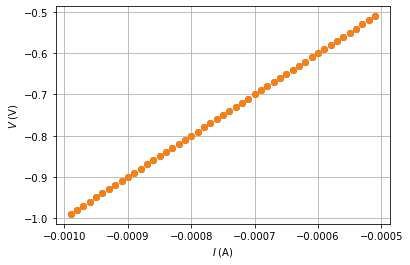

In [4]:
%matplotlib inline 
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft


choosen_experiments = [1,2]
start_index = 1
end_index = 50


for i in choosen_experiments:
    dataset = load_by_id(i)
    df = dataset.get_data_as_pandas_dataframe()
    plt.plot(df["I"]["I"].to_list()[start_index:end_index],df["V"]["V"].to_list()[start_index:end_index],'o')

axes = plt.gca()
plt.grid(True)
plt.ylabel('$V \; (\mathrm{V})$')
plt.xlabel('$I \;(\mathrm{A})$')
plt.savefig("./Two_datasets_in_one_plot.pdf", bbox_inches='tight')

## Extracting data form a database 

One problem that I ran across in the very beginning of working with QCoDeS was that it is not simply possible to 
have two jupyter notebook acessing the same database at the same time. Once one script is using the database it is blocked for all others. This brings me to two problems:

1. How to store data from different setups?
2. How to store data into a database using a measurement notebook and at the same time use a different notebook to perfrom data anaylsis on that very same dataset?


The first porblem has been solved by giving every setup (or station if you want to) its own database which it can write to. The second problem can be solved by exporting the data into another database for analysis. In the beginng as a workaround we copied the database, but as more data is collected this is not so practiable anymore, so here is how you extract data into another database:

In [3]:
from qcodes.dataset.database_extract_runs import extract_runs_into_db

extract_runs_into_db(qc.config["core"]["db_location"], './analysis.db', 1,2,9)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 385.65it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 409.00it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 291.88it/s]


Lets have a look which data is in our new database:

In [14]:
qc.config["core"]["db_location"]='./analysis.db'
initialise_database()

experiments = qc.experiments()
for exp in experiments:
    print('name: '+exp.name+', sample: '+exp.sample_name)
    #This prints the data sets included such as the number of the experiment (ID) that we will need:
    print(exp.data_sets())
    
#Using GUID for identification:
print('The GUID iof experiment 3 is '+str(exp.data_set(3).guid))

name: DC-IV-Sweep, sample: Test-Resistor
[results #1@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/analysis.db
-----------------------------------------------------------------------------------------------
V_set - numeric
I - numeric
V - numeric
t - numeric, results #2@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/analysis.db
-----------------------------------------------------------------------------------------------
V_set - numeric
I - numeric
V - numeric
t - numeric, results #3@/Users/jonaskolzer/Documents/Quantacademy/QCoDeS Series/QCoDeS-Tutorials/analysis.db
-----------------------------------------------------------------------------------------------
src3_v5 - numeric
src3_v6 - numeric]
The GUID iof experiment 3 is aaaaaaaa-0000-0000-0000-0172e14fbf59


## Sources

Link to the QCoDeS Documentation:
https://qcodes.github.io/Qcodes/examples/DataSet/The-Experiment-Container.html


Interesting in that context is also linking analysed data to the raw data: 
https://qcodes.github.io/Qcodes/examples/DataSet/Linking%20to%20parent%20datasets.html

Extracting data from a database:
https://qcodes.github.io/Qcodes/examples/DataSet/Extracting-runs-from-one-DB-file-to-another.html